# Notebook sur le tracking vidéo

Dans ce notebook nous allons voir comment on peut lire une vidéo, extraire les frames de la vidéo, faire de la détection (estimation de pose) et faire du tracking sur cette détection.

**Plan:**
1. Lecture de vidéo
2. Manipulation de frames
3. Estimation de pose
4. Utilisation des données

### 0. Import 

In [185]:
import cv2
import os
import subprocess
import json
import pandas as pd
import csv
from PIL import Image
from ipyfilechooser import FileChooser
import IPython.display
import ipywidgets 
import numpy as np

### 1. Lecture de vidéo

Pour lire les vidéos et manipuler les images, nous allons utiliser la bibliothèque <a href='https://opencv.org/'>OpenCV<a>

In [148]:

#Bouton pour la selection de l'image


fdialog_vid = FileChooser(
    os.getcwd(),
    filename='test.txt',
    title='<b>FileChooser example</b>',
    show_hidden=False,
    select_default=True,
    show_only_dirs=False
)

display(fdialog_vid)

# Get the selected value
fdialog_vid.selected

# Callback example
def change_title(chooser):
    chooser.title = '<b>Sélection effectuée</b>'

# Register callback function
fdialog_vid.register_callback(change_title)

# Set or change the title
fdialog_vid.title = '<b>Selectionner une vidéo</b>'

# Show hidden files, change rows to 10, and hide folder icons
fdialog_vid.show_hidden = True
fdialog_vid.rows = 10
fdialog_vid.dir_icon = None

# Change folder icon to `os.sep` and append it to the folder name
fdialog_vid.dir_icon = os.sep
fdialog_vid.dir_icon_append = True



# Switch to folder-only mode
fdialog_vid.show_only_dirs = True

# Switch back to standard mode
fdialog_vid.show_only_dirs = False


# Set multiple file filter patterns (uses https://docs.python.org/3/library/fnmatch.html)
fdialog_vid.filter_pattern = ['*.mp4', '*.avi', '*.mov']

# Change the default path and filename
fdialog_vid.default_path = os.path.abspath(os.getcwd())
fdialog_vid.default_filename = 'readme.md'

# Reset to defaults and clear the selected value
fdialog_vid.reset()




FileChooser(path='C:\Users\ReViVD\Documents\GitHub\tuto-video-tracking', filename='test.txt', title='<b>FileCh…

In [149]:
#Lecture de la vidéo
video_name = fdialog_vid.selected

vidcap = cv2.VideoCapture(video_name)
    

### 2. Manipulation de frames

Pour la manipulation de frames, nous allons reprendre la bibliothèque <a href='https://opencv.org/'>OpenCV<a>

In [233]:
#Extraction des frames
if not os.path.isdir('output'):
    os.mkdir('output')
frame_path = os.path.join('output','frames')

if not os.path.isdir(frame_path):
    os.mkdir(frame_path)
    
success, image = vidcap.read()
i = 0
while success != False:
    #Lecture des frames
    success, image = vidcap.read()
    
    #Sauvegarder les frames
    if success:
        cv2.imwrite(os.path.join(frame_path, str(i) + ".jpg"), image)
    else:
        break
    
    i += 1

### 3. Estimation de la pose

Pour faire l'estimation de pose, nous allons utiliser <a href='https://github.com/CMU-Perceptual-Computing-Lab/openpose'>Openpose<a>

In [151]:
#Cette partie peut être faite si l'on a installé Openpose

"""# Répertorier les frames dans le dossier où elles ont été sauvegardées

liste_frame = os.listdir(frame_path)

if not os.path.isdir(os.path.join('output','openpose_json')):
    os.mkdir(os.path.join('output','openpose_json'))
#Lancer Openpose sur les frames, Choisir où on enregistre les frames
chemin_sauvegarde = os.path.join('output','openpose_json')

path_openpose = "C:\\Users\\ReViVD\\Downloads\\openpose-1.7.0-binaries-win64-gpu-python3.7-flir-3d_recommended\\openpose"
dossier_courant = os.getcwd()
os.chdir(path_openpose)
if not os.path.isdir(chemin_sauvegarde):
    os.mkdir(chemin_sauvegarde)
subprocess.call("bin\\OpenPoseDemo.exe --video "+os.path.join(dossier_courant,video_name)+" --write_json "+os.path.join(dossier_courant,chemin_sauvegarde)+' --write_video '+os.path.join(dossier_courant,video_name.replace('.mp4','_openpose.avi'))+' --display 0')

#subprocess.call("bin\\OpenPoseDemo.exe --image_dir "+os.path.join(dossier_courant,'test')+" --write_images "+os.path.join(dossier_courant,'test2')+" --write_json "+os.path.join(dossier_courant,chemin_sauvegarde)+ ' --display 0')
os.chdir(dossier_courant)"""

    

### Keypoints Openpose

<img src="utils/openpose_keypoints.png" width=300 height=300 />

### 4. Utilisation des données

#### 4.1. Sauvegarder les données dans un format csv

In [152]:
#Répertorier les json dans le dossier où elles ont été sauvegardées
liste_json_openpose = os.listdir(chemin_sauvegarde)

#Ouvrir les json et les récupérer les données
liste_toutes_valeurs = []
for le_json in liste_json_openpose:
        if '.json' in le_json: #test pour vérifier que c'est bien un fichier json
            data = pd.read_json(os.path.join(chemin_sauvegarde,le_json), lines=True)
            if len(data['people'])>0: #test pour vérifier qu'il y a bien au moins une personne détectée
                for i in range(len(data['people'][0])):
                    data_keypoints = data['people'][0][i]['pose_keypoints_2d']
                    for j in range(0,len(data_keypoints),3): #partie permettant de récupérer les coordonnées x, y et la confiance à chaque fois
                        liste_un_json = []
                        liste_un_json.append(int(le_json.split('_')[-2]))
                        liste_un_json.append(i)
                        liste_un_json.append(j//3)
                        liste_un_json.append(data_keypoints[j])
                        liste_un_json.append(data_keypoints[j+1])
                        liste_un_json.append(data_keypoints[j+2])
                        liste_toutes_valeurs.append(liste_un_json)

#Créer un fichier csv à l'aide des json créés par Openpose
chemin_csv_openpose = os.path.join('output','csv','openpose.csv') #chemin où on va enregistrer le csv contenant les informations openpose
if not os.path.isdir(os.path.split(chemin_csv_openpose)[0]):
    os.mkdir(os.path.split(chemin_csv_openpose)[0]) #Créer le dossier s'il n'existe pas déjà

#Ecriture du fichier
with open(chemin_csv_openpose,'w',newline='') as fichiercsv:
    writer=csv.writer(fichiercsv)
    writer.writerow(['frame','numero_pers','joint','x','y','confience'])
    for l in liste_toutes_valeurs:
        writer.writerow(l)



#### 4.2. Première approche de tracking

Pour calculer le tracking, on va regarder pour une personne donnée, sur l'image suivante, quel personne se est la plus proche d'elle. Ce que l'on appelle proche est la distance entre deux positions. Etant donné que l'on a une estimation de pose des personnes, on va pouvoir faire des calculs de distances pour chaque membre de chauqe personne, ce qui signifie que l'on considère plusieurs points d'intérêts pour chaque personnes ce qui renforce la robustesse du tracking

In [162]:

#tracking
#Les fonctions suivantes permettent de calculer le tracking des joueurs et de ressortir les résultats sous forme de listes

def openpose_json2list(chemin_json): 
    '''Prend en entrée le chemin des fichiers contenant les fichiers json. 
    En sortie il sort une liste de liste: ['frame','numero_pers','joint','x','y','confience']
    '''
    dossier = os.listdir(chemin_json)
    liste_sortie = []
    val_precedente_existe = [0]
    val_precedente = [[]]
    for les_json in dossier:
        if '.json' in les_json:
            with open(os.path.join(chemin_json,les_json)) as mon_json:
                data = json.load(mon_json)
                if len(data['people'])>0:
                    for i in range(len(data['people'])):
                        data_keypoints = data['people'][i]['pose_keypoints_2d']
                        if (len(data['people'])>len(val_precedente_existe)):
                            val_precedente_existe.append(0)
                            val_precedente.append([])
                        for j in range(0,len(data_keypoints),3):
                            liste_un_json = []
                            liste_un_json.append(int(les_json.split('_')[-2]))
                            liste_un_json.append(i)
                            liste_un_json.append(j//3)
                            liste_un_json.append(data_keypoints[j])
                            liste_un_json.append(data_keypoints[j+1])
                            liste_un_json.append(data_keypoints[j+2])
                            liste_sortie.append(liste_un_json)
                            if val_precedente_existe[i]:
                                if ((data_keypoints[j] != 0) and (val_precedente[i][j] != 0)):
                                    liste_un_json.append(data_keypoints[j]-val_precedente[i][j])
                                else:
                                    liste_un_json.append(0)
                                if ((data_keypoints[j+1] != 0) and (val_precedente[i][j+1] != 0)):
                                    liste_un_json.append(data_keypoints[j+1]-val_precedente[i][j+1])
                                else:
                                    liste_un_json.append(0)
                            else:
                                liste_un_json.append(0)
                                liste_un_json.append(0)
                        val_precedente[i] = data_keypoints
                        val_precedente_existe[i] = 1
    return(liste_sortie)



def openpose_json2list_tracking(chemin_json): 
    '''Elle prend en entrée le chemin des fichiers contenant les fichiers json. 
    En sortie [[1,2,3,4],[2,3,1,0],...], elle sort une liste de liste contenant le numéro de la personne identifiée (la place dans les sous listes correspondent à l'ordre des personnes dans les json openpose).
    '''
    dossier = os.listdir(chemin_json)
    liste_sortie = []
    val_precedente_existe = [0]
    val_precedente = []
    val_actuelle = [[]]
    nb_personnes_tot = -1
    liste_personnes_disparues = []
    val_precedente = {}
    for les_json in dossier:
        if '.json' in les_json:
            with open(os.path.join(chemin_json,les_json)) as mon_json:
                data = json.load(mon_json)
                if len(data['people'])>0:
                    if nb_personnes_tot == -1:
                        nb_personnes_tot = len(data['people'])
                    nb_personnes = len(data['people'])
                    val_actuelle = []
                    liste_joueurs_avec_vals_moyennes_deplacements = []
                    for i in range(nb_personnes):
                        data_keypoints = data['people'][i]['pose_keypoints_2d']
                        val_actuelle.append(data_keypoints)
                        liste_un_joueur_avec_vals_moyennes_deplacements = []
                        #On fait un calcul de distance d'une frame à l'autre en chaque personnes en se basant sur ses keypoints Openpose
                        for k in range(len(val_precedente)):
                            x = 0
                            y = 0
                            nb_points = 1
                            for j in range(0,len(data_keypoints),3):
                                if ((data_keypoints[j] != 0) and (val_precedente[k][j] != 0)):  #pour retirer les cas où openpose ne détecte pas un point car il le met à (0,0) et ça fausse tout
                                    x += abs(data_keypoints[j] - val_precedente[k][j])
                                    y += abs(data_keypoints[j+1] - val_precedente[k][j+1])
                                    nb_points += 1
                            if x+y == 0:
                                x = y = 5000
                            liste_un_joueur_avec_vals_moyennes_deplacements.append((x+y)/nb_points) #on aurait pu faire sqrt((x²+y²)/nb_points) mais je ne pense pas que ce soit utile
                        liste_joueurs_avec_vals_moyennes_deplacements.append(liste_un_joueur_avec_vals_moyennes_deplacements)
                    if liste_joueurs_avec_vals_moyennes_deplacements[0] != []:
                        position_des_joueurs = []
                        for j in range(len(liste_joueurs_avec_vals_moyennes_deplacements)):
                            if min(liste_joueurs_avec_vals_moyennes_deplacements[j]) < 70:
                                position_des_joueurs.append(np.argmin(liste_joueurs_avec_vals_moyennes_deplacements[j]))
                            else:
                                position_des_joueurs.append(nb_personnes_tot)
                                nb_personnes_tot += 1
                        #position_des_joueurs = [np.argmin(liste_joueurs_avec_vals_moyennes_deplacements[i]) for i in range(len(liste_joueurs_avec_vals_moyennes_deplacements))]
                        
                    else:
                        position_des_joueurs = [i for i in range(len(liste_joueurs_avec_vals_moyennes_deplacements))]
                        nb_personnes = len(position_des_joueurs)
                    liste_sortie.append(position_des_joueurs[:])



                    
                    for i in position_des_joueurs: #mettre un dictionnaire pour traiter les cas où les personnes ne sont plus détectées/
                        val_precedente[i] = val_actuelle[position_des_joueurs.index(i)]
                else:
                    liste_sortie.append([])
    #print(liste_sortie)
    return(liste_sortie)


#### 4.3. Sauvegarder les données de tracking

In [ ]:
#Création du csv Openpose prennant en compte le tracking
def creation_csv_tracking(list_openpose_json,liste_tracking_json,chemin_csv):
    '''
        Fonction permettant de créer un csv contenant les informations openpose avec le tracking des joueurs
        Entrée: Une liste resortie par openpose_json2list() contenant les informations d'openpose, 
                une liste resortie par openpose_json2list_tracking() contenant les informations de suivi de joueurs, 
                le chemin où enregistrer les fichier csv et le nom du fichier csv,
        Sortie: Création d'un fichier csv avec les informations openpose avec chaque ligne de type ['frame','numero_pers','joint','x','y','tracking']
    '''
    with open(os.path.join(chemin_csv),'w',newline='') as fichiercsv:
        writer=csv.writer(fichiercsv)
        writer.writerow(['frame','numero_pers','joint','x','y','tracking'])
        frame_openpose = list_openpose_json[0][0]
        personne_openpose = list_openpose_json[0][1]
        for row in list_openpose_json:
            if liste_tracking_json[row[0]] != []:
                writer.writerow([row[0],liste_tracking_json[row[0]][row[1]],row[2],row[3],row[4],liste_tracking_json[row[0]][row[1]]])

creation_csv_tracking(openpose_json2list(os.path.join(os.path.join('output','openpose_json'))),
                         openpose_json2list_tracking(os.path.join('output','openpose_json'))
                         ,os.path.join('output','csv','openpose_tracking.csv'))    

#### 4.4. Exploitation des données sauvegardées

##### 4.4.1 Bounding box des joueurs

En utilisant l'estimation de pose, on va récupérer les maximums et minimums des coordonnées des squelettes des joueurs pour pouvoir calculer une box englobant les joueurs

In [226]:
#Fonction permettant de tracer un rectangle à l'aide de 4 points
def draw_rect_video(frame, posA = (10, 50), posB = (20, 70), color = (255,0,0)):
    """draw a rectangle given 2 points"""
    #c = hex2rgb(colors[0])
    #color = (c[2], c[1], c[0])
    thickness = 6
    cv2.rectangle(frame, posA, posB, color, thickness)

    return


#Tracer des bounding box autour des joueurs à l'aide de l'estimation de pose
def bounding_box(num_frame,chemin_image,num_personne,chemin_csv,chemin_sauvegarder,afficher_image=True):
    '''
        Fonction permettant de tracer une box autour d'une personne à l'aide du csv tracking openpose
        Entrée: le numéro de la frame, le chemin de l'image, le numéro de la personne, le chemin du csv Openpose tracking,
                le chemin où on veut sauvegarder l'image avec la box, un booléen qui indique si on veut afficher l'image
    '''
    if not os.path.isdir(chemin_sauvegarder):
        os.mkdir(chemin_sauvegarder)
    #Ouvir le fichier csv
    with open(chemin_csv, newline='') as csvfile:
        reader = csv.reader(csvfile)
        next(reader) #permet de ne pas prendre l'en-tête
        max_x,max_y,min_x,min_y = -1,-1,-1,-1
        for row in reader:
            if ((int(row[0]) == num_frame) and (int(row[5]) == num_personne)):
                if max_x == -1:
                    max_x,max_y,min_x,min_y = float(row[3]),float(row[4]),float(row[3]),float(row[4])
                else:
                    if ((float(row[3]) > max_x)):
                        max_x = float(row[3])
                    if ((float(row[4]) > max_y)):
                        max_y = float(row[4])
                    if (((float(row[3]) < min_x) or (min_x == 0)) and (float(row[3]) != 0)):
                        min_x = float(row[3])
                    if (((float(row[4]) < min_y) or (min_y == 0)) and (float(row[4]) != 0)):
                        min_y = float(row[4])
    
    image = cv2.imread(chemin_image) #lire image
    draw_rect_video(image, (int(max_x),int(max_y)), (int(min_x),int(min_y))) #tracer rectangle
    cv2.putText(image, str(num_personne), (int(min_x),int(min_y)), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255))
    
    cv2.imwrite(os.path.join(chemin_sauvegarder,str(num_frame)+'.jpg'),image) #enregistrer image avec box
    
    if afficher_image:
        IPython.display.display(PIL.Image.fromarray(cv2.cvtColor(cv2.imread(os.path.join(chemin_sauvegarder,str(num_frame)+'.jpg')), cv2.COLOR_BGR2RGB)))
    
#bounding_box(0,os.path.join('output','0.jpg'),0,'openpose.csv',os.path.join('output','frames_boxes'))
#Faire des premiers calculs de métrics (vitesses, distances de déplacements,...)
#Faire bounding box Couleur de la raquette



In [235]:
#tracer les box d'une personne sur tout un dossier en enregistrant les images avec les box
nom_dossier = os.path.join('output','frames')
nom_dossier_boxes = os.path.join('output','frames_boxes')
liste_images = os.listdir(nom_dossier)
liste_images.sort()
liste_images.sort(key=len)
with open(os.path.join('output','csv','openpose_tracking.csv'), newline='') as csvfile:
    reader = csv.reader(csvfile)
    next(reader) #permet de ne pas prendre l'en-tête
    liste_frame_personne = []
    for row in reader:
        if [int(row[0]),int(row[5])] not in liste_frame_personne:
            if int(row[0]) not in liste_images:
                break
            
            liste_frame_personne.append([int(row[0]),int(row[5])])
            if (int(row[5]) == 0):
                bounding_box(int(row[0]),os.path.join(nom_dossier,liste_images[int(row[0])]),int(row[5]),os.path.join('output','csv','openpose_tracking.csv'),nom_dossier_boxes,afficher_image=False)
            else:
                bounding_box(int(row[0]),os.path.join(nom_dossier_boxes,liste_images[int(row[0])]),int(row[5]),os.path.join('output','csv','openpose_tracking.csv'),nom_dossier_boxes,afficher_image=False)

##### 4.4.1 Détection de la couleur de la raquette

Pour la détection de la couleur de la raquette, on va se servir de l'estimation de pose pour définir une région autour de la main droite du joueur et ensuite en faisant une annalyse de la couleur moyenne on va détecter la couleur

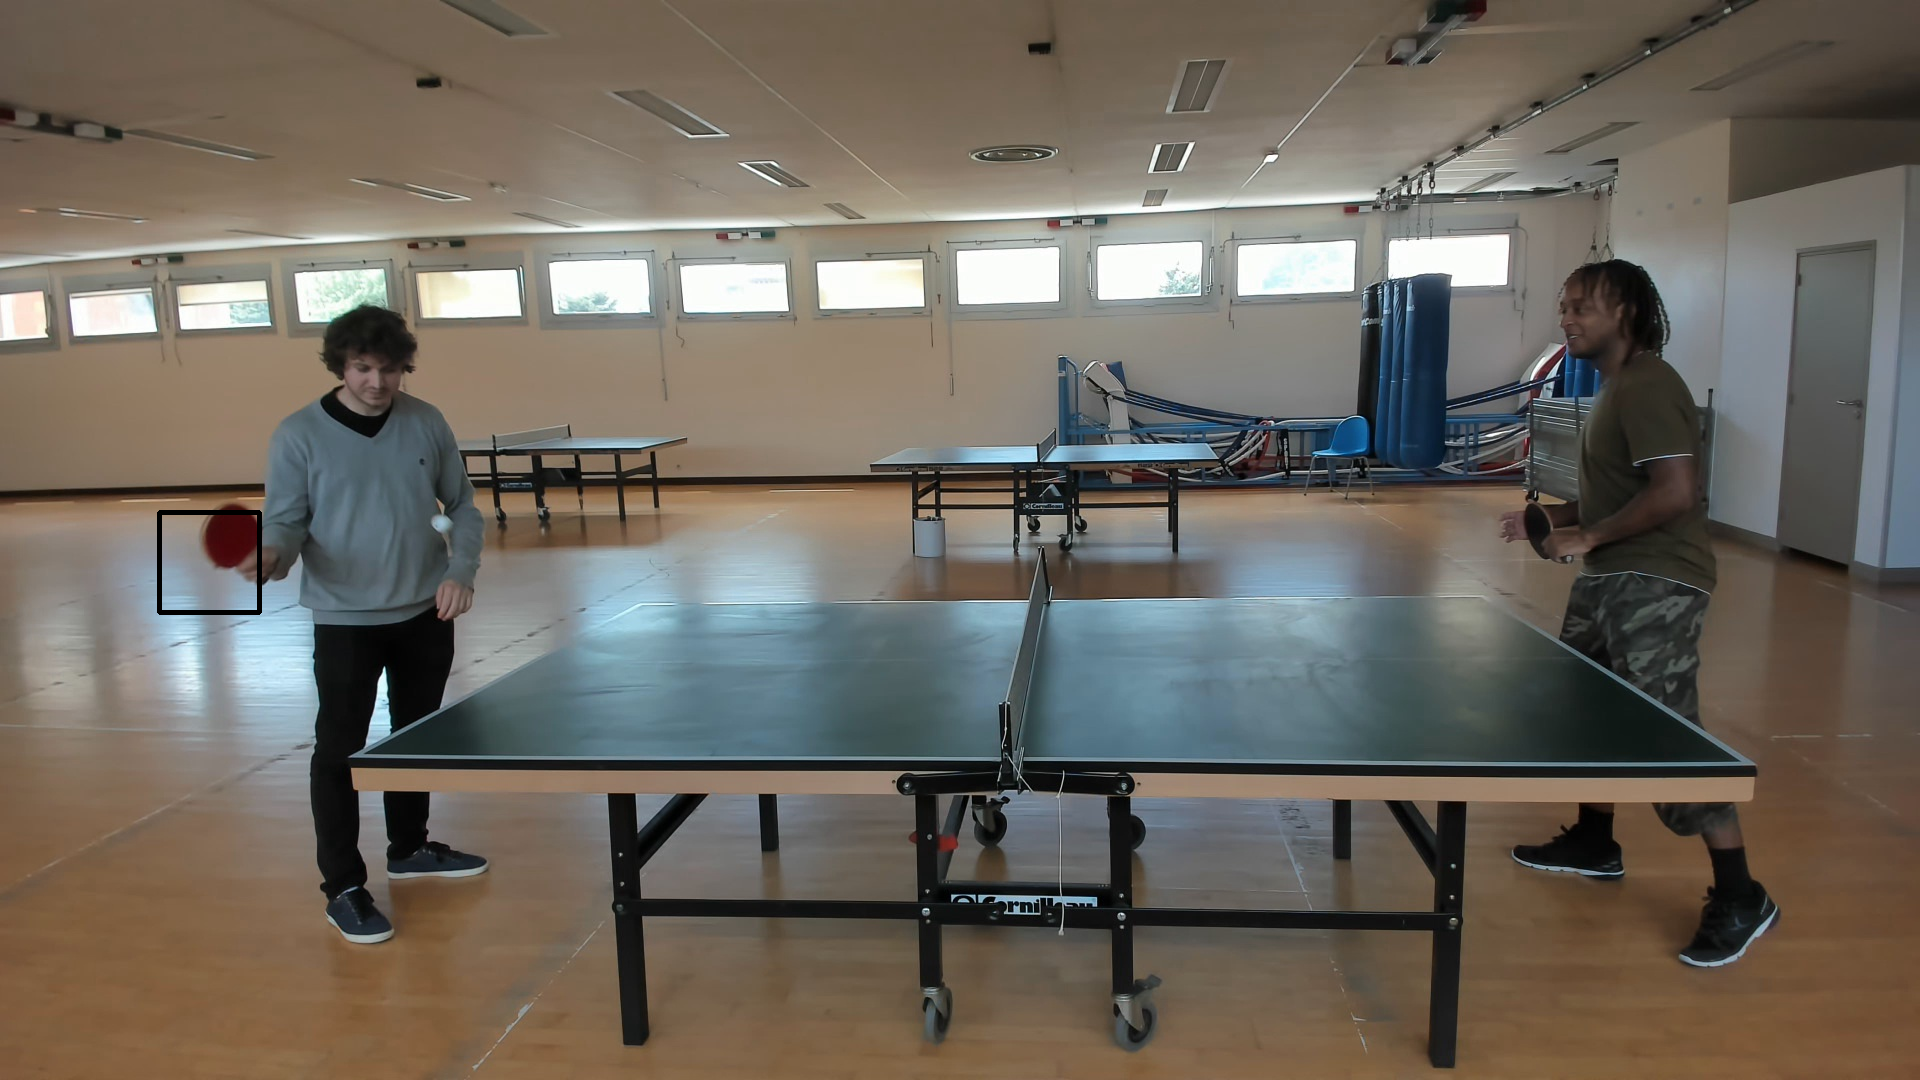

In [236]:
#Detecter la couleur de la raquette

def detect_couleur_raquette(chemin_image,point_main,point_coude):
    '''
        Fonction permettant de détecter la couleur de la raquette
        Entrée: le chemin de l'image, les coordonnées de la main droite, les coordonnées du coude droit
        Sortie: Trace sur l'image le rectangle contenant la raquette de la couleur détectée
    '''
    #dir = os.listdir('raquette/')
    facteur = 100
    
    frame = cv2.cvtColor(cv2.imread(chemin_image), cv2.COLOR_BGR2RGB)
    rouge = 0
    noir = 0
    img_hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
    if point_main[0] < point_coude[0]: 
        for i in range(min(point_main[0],point_main[0]-facteur),max(point_main[0],point_main[0]-facteur)-3,4):
            for j in range(min(point_main[1]+facteur//2,point_main[1]-facteur//2),max(point_main[1]+facteur//2,point_main[1]-facteur//2)-3,4):
                if ((i <= frame.shape[0]) and (j <= frame.shape[1])):
                    if ((frame[i][j][0] > frame[i][j][1]+30) and (frame[i][j][0] > frame[i][j][2]+30)):
                        rouge += 1
                    elif((frame[i][j][0] < 55) and (frame[i][j][1] < 55) and (frame[i][j][2] < 55)):
                        #print('noir')
                        noir += 1
        if rouge > noir:
            cv2.rectangle(frame,(point_main[0],point_main[1]+facteur//2),(point_main[0]-facteur,point_main[1]-facteur//2),(255,0,0), 3)
        else:
            cv2.rectangle(frame,(point_main[0],point_main[1]+facteur//2),(point_main[0]-facteur,point_main[1]-facteur//2),(0,0,0), 3)
        #cv2.imwrite('raquette/raquette_'+str(len(dir))+'.jpg',frame[min(point_main[1]+facteur//2,point_main[1]-facteur//2):max(point_main[1]+facteur//2,point_main[1]-facteur//2),min(point_main[0],point_main[0]-facteur):max(point_main[0],point_main[0]-facteur)])
    else:
        for i in range(min(point_main[0],point_main[0]+facteur),max(point_main[0],point_main[0]+facteur)-3,4):
            for j in range(min(point_main[1]+facteur//2,point_main[1]-facteur//2),max(point_main[1]+facteur//2,point_main[1]-facteur//2)-3,4):
                if ((i <= frame.shape[0]) and (j <= frame.shape[1])):
                    if ((frame[i][j][0] > frame[i][j][1]+30) and (frame[i][j][0] > frame[i][j][2]+30)):
                        rouge += 1
                    elif((frame[i][j][0] < 55) and (frame[i][j][1] < 55) and (frame[i][j][2] < 55)):
                        #print('noir')
                        noir += 1
        if rouge > noir:
            cv2.rectangle(frame,(point_main[0],point_main[1]+facteur//2),(point_main[0]+facteur,point_main[1]-facteur//2),(255,0,0), 3)
        else:
            cv2.rectangle(frame,(point_main[0],point_main[1]+facteur//2),(point_main[0]+facteur,point_main[1]-facteur//2),(0,0,0), 3)
        #cv2.imwrite('raquette/raquette_'+str(len(dir))+'.jpg',frame[min(point_main[1]+facteur//2,point_main[1]-facteur//2):max(point_main[1]+facteur//2,point_main[1]-facteur//2),min(point_main[0],point_main[0]-facteur):max(point_main[0],point_main[0]-facteur)])

    IPython.display.display(PIL.Image.fromarray(frame))

    
#Appliquer sur une image
def detection_couleur_raquette_une_image(chemin_csv,numero_frame,numero_personne):
    '''
        Fonction permettant de tracer sur une image une box de la couleur du côté de la raquette
        Entrée: le chemin du csv contenant les annotations Openpose, le numéro de la frame de l'image voulue, le numéro de la personne voulue
        Sortie: affichage sur l'image de la boxe
    '''
    with open(os.path.join('output','csv','openpose.csv'), newline='') as csvfile:
        reader = csv.reader(csvfile)
        next(reader) #permet de ne pas prendre l'en-tête
        for row in reader:
            if ((int(row[0]) == numero_frame) and (int(row[1]) == numero_personne)):
                if (int(row[2]) == 3):#coude droit (6 pour le gauche)
                    point_coude = [int(float(row[3])),int(float(row[4]))]
                if (int(row[2]) == 4):#main (7 pour le gauche)
                    point_main = [int(float(row[3])),int(float(row[4]))]
    detect_couleur_raquette(os.path.join('output','frames',str(numero_frame)+'.jpg'),point_main,point_coude)
detection_couleur_raquette_une_image(os.path.join('output','csv','openpose.csv'),59,0)